## **cnn.py**

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import fashion_mnist, mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten
from keras import backend as k

def cnn_mnist(res):
  if (res == "original"):
    x_train, y_train, x_test, y_test = load("fashion")
  elif (res == "low"):
    x_train, y_train, x_test, y_test = load("original")

  x_train, y_train, x_test, y_test, input_x = process(x_train, y_train, x_test, y_test)

  if (res == "original"):
    model = build_org_res(input_x)
  elif (res == "low"):
    x_train, x_test, input_x = down_sample(x_train, x_test, input_x)
    model = build_low_res(input_x)

  train_fit(model, x_train, y_train, x_test, y_test)
  return model, x_train, y_train, x_test, y_test

def load(type):
  if (type == "fashion"):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  elif (type == "original"):
     (x_train, y_train), (x_test, y_test) = mnist.load_data()

  return x_train, y_train, x_test, y_test

def process(x_train, y_train, x_test, y_test):
  # Reshape images to fit the CNN input requirement
  img_rows, img_cols = 28, 28

  if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_x = (1, img_rows, img_cols)
  else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_x = (img_rows, img_cols, 1)

  # Normalize pixel values to be between 0 and 1
  x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
  y_train, y_test = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test)
  return x_train, y_train, x_test, y_test, input_x

def build_org_res(input_x):
  input_x_org = Input(shape=input_x)
  layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_x_org)
  layer2 = MaxPooling2D((2, 2))(layer1)
  layer3 = Conv2D(64, (3, 3), activation='relu')(layer2)
  layer4 = MaxPooling2D((3, 3))(layer3)  # Changed to match your new structure
  layer5 = Dropout(0.5)(layer4)  # Dropout layer
  layer6 = Flatten()(layer5)
  layer7 = Dense(250, activation='sigmoid')(layer6)  # Changed Dense layer size and activation
  output_original = Dense(10, activation='softmax')(layer7)

  model_org = Model([input_x_org], output_original)
  model_org.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])
  return model_org

def down_sample(x_train, x_test, input_x):
  # Downsample images using average pooling
  input_layer_org = Input(shape=input_x)
  output_layer_low = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(input_layer_org)
  model_low_res = Model(inputs=input_layer_org, outputs=output_layer_low)

  # Apply the downsampling transformation
  x_train_low = model_low_res.predict(x_train)
  x_test_low = model_low_res.predict(x_test)

  # Adjust the input shape for the downsampled image
  if k.image_data_format() == 'channels_first':
      input_shape_low_res = (1, 7, 7)
  else:
      input_shape_low_res = (7, 7, 1)

  return x_train_low, x_test_low, input_shape_low_res


def build_low_res(input_x_low_res):
  input_x_low = Input(shape=input_x_low_res)
  layer1 = Conv2D(16, (3, 3), activation='relu')(input_x_low)
  layer2 = MaxPooling2D((2, 2))(layer1)
  layer3 = Conv2D(32, (2, 2), activation='relu')(layer2)
  layer4 = Flatten()(layer3)
  layer5 = Dense(32, activation='relu')(layer4)
  output_low = Dense(10, activation='softmax')(layer5)

  model_low = Model(inputs=[input_x_low], outputs=output_low)
  model_low.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  return model_low


def train_fit(model, x_train, y_train,x_test, y_test):
  # Train the model
  results = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

  model.summary()
  test_loss, test_acc = model.evaluate(x_test, y_test)
  print('Test loss:', test_loss)
  print('Test accuracy:', test_acc)

## **graph.py**

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def graph_mnist(classifier, num_runs, num_epoch, model, x_train, y_train, x_test, y_test):
  if (classifier == "CNN"):
    accs, val_accs = collect_data(num_runs, num_epoch, model, x_train, y_train, x_test, y_test)
  elif (classifier == "SVM"):
    accs, val_accs = collect_data_svm(num_runs, num_epoch, model, x_train, y_train, x_test, y_test)

  mean_accuracy, std_accuracy, mean_val_accuracy, std_val_accuracy = process_data(accs, val_accs)

  plot_data(classifier, num_epoch, num_runs, mean_accuracy, std_accuracy, mean_val_accuracy, std_val_accuracy)


def collect_data(num_runs, num_epoch, model, x_train, y_train, x_test, y_test):
    # Initialize lists to store metrics
    accs, val_accs = [], []
    for _ in range(num_runs):
        history = model.fit(x_train, y_train, epochs=num_epoch, validation_data=(x_test, y_test), verbose=0)
        accs.append(history.history['accuracy'])
        val_accs.append(history.history['val_accuracy'])
    return accs, val_accs

def collect_data_svm(num_runs, num_epoch, model, x_train, y_train, x_test, y_test):
  accs, val_accs = [], []
  for run in range(num_runs):
    run_accs, run_val_accs = [], []
    for step in range(1, num_epoch + 1):
      subset_size = int(len(x_train) * (step / num_epoch))
      x_train_subset, x_val, y_train_subset, y_val = train_test_split(x_train, y_train, train_size=((step / num_epoch)*0.75), shuffle=True)
      model.fit(x_train_subset, y_train_subset)
      train_accuracy = model.score(x_train_subset, y_train_subset)
      test_accuracy = model.score(x_test, y_test)
      run_accs.append(train_accuracy)
      run_val_accs.append(test_accuracy)
    accs.append(run_accs)
    val_accs.append(run_val_accs)
  return accs, val_accs

def process_data(accs, val_accs):
  # Convert lists to numpy arrays for calculation
  accs, val_accs = np.array(accs), np.array(val_accs)

  # Calculate means and standard deviations
  mean_accuracy = np.mean(accs, axis=0)
  std_accuracy = np.std(accs, axis=0)
  mean_val_accuracy = np.mean(val_accs, axis=0)
  std_val_accuracy = np.std(val_accs, axis=0)

  print(mean_accuracy, std_accuracy, mean_val_accuracy, std_val_accuracy)

  return mean_accuracy, std_accuracy, mean_val_accuracy, std_val_accuracy

def plot_data(classifier, num_epoch, num_runs, mean_accuracy, std_accuracy, mean_val_accuracy, std_val_accuracy):
  epochs = range(1, num_epoch+1)

  # Plot with confidence intervals
  plt.figure(figsize=(10, 6))

  # Training and Validation Accuracy
  plt.plot(epochs, mean_accuracy, label='Training Accuracy')
  plt.fill_between(epochs, mean_accuracy - 1.96*(std_accuracy/np.sqrt(num_runs)), mean_accuracy + 1.96*(std_accuracy/np.sqrt(num_runs)), alpha=0.1)
  plt.plot(epochs, mean_val_accuracy, label='Testing Accuracy')
  plt.fill_between(epochs, mean_val_accuracy - 1.96*(std_val_accuracy/np.sqrt(num_runs)), mean_val_accuracy + 1.96*(std_val_accuracy/np.sqrt(num_runs)), alpha=0.1)

  if (classifier == "CNN"):
    plt.title('Training and Testing Accuracy over Epochs')
    plt.xlabel('Epoch')
  elif (classifier == "SVM"):
    plt.title('Training and Testing Accuracy over Varying Subsets')
    plt.xlabel('Subset Size as "Epochs"')

  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

## **svm.py**

In [54]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import numpy as np
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten
from keras.models import Model
import matplotlib.pyplot as plt

def svm_mnist(res):
  x_train, y_train, x_test, y_test = svm_load()

  if(res=="low"):
    x_train, x_test = svm_down_sample(x_train, x_test)

  x_train, x_test = svm_process(x_train, x_test)

  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

  svm_model = svm_build()
  svm_train_fit(x_train, y_train, x_val, y_val, svm_model)

  return svm_model, x_train, y_train, x_test, y_test

def svm_load():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  return x_train, y_train, x_test, y_test

def svm_process(x_train, x_test):
  x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255
  x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255
  return x_train, x_test

def svm_build():
  svm_model = SVC(kernel='rbf', gamma='scale', max_iter=250)
  return svm_model

def svm_train_fit(x_train, y_train, x_test, y_test, svm_model):
  svm_model.fit(x_train, y_train)
  test_predictions = svm_model.predict(x_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, test_predictions)
  print(f"Test Accuracy: {accuracy}")


def svm_down_sample(x_train, x_test):
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  input_x = (28, 28, 1)  # Original shape for MNIST
  input_layer_org = Input(shape=input_x)
  output_layer_low = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(input_layer_org)
  model_low_res = Model(inputs=input_layer_org, outputs=output_layer_low)

  x_train_low = model_low_res.predict(x_train)
  x_test_low = model_low_res.predict(x_test)

  # Reshape back to fit SVM input requirements
  x_train_low = x_train_low.reshape((x_train_low.shape[0], -1))
  x_test_low = x_test_low.reshape((x_test_low.shape[0], -1))

  return x_train_low, x_test_low

In [57]:
import timeit

tic = timeit.default_timer()

model_org, x_train_org, y_train_org, x_test_org, y_test_org = cnn_mnist("original")

toc = timeit.default_timer()

print(toc - tic)

Epoch 1/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.6196 - accuracy: 0.7707 - val_loss: 0.4611 - val_accuracy: 0.8274
Epoch 2/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.4475 - accuracy: 0.8300 - val_loss: 0.3849 - val_accuracy: 0.8570
Epoch 3/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.3974 - accuracy: 0.8500 - val_loss: 0.3551 - val_accuracy: 0.8674
Epoch 4/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.3640 - accuracy: 0.8626 - val_loss: 0.3327 - val_accuracy: 0.8761
Epoch 5/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.3439 - accuracy: 0.8703 - val_loss: 0.3208 - val_accuracy: 0.8821
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.3266 - accuracy: 0.8765 - val_loss: 0.3097 - val_accuracy: 0.8841
Epoch 7/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.3131 - accuracy: 0.8820 - val_loss: 0.2968 -

In [58]:
import timeit

tic = timeit.default_timer()

model_low, x_train_low, y_train_low, x_test_low, y_test_low = cnn_mnist("low")

toc = timeit.default_timer()

print(toc - tic)

313/313 [==============================] - 1s 3ms/step
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7067 - accuracy: 0.7896 - val_loss: 0.3870 - val_accuracy: 0.8806
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3436 - accuracy: 0.8928 - val_loss: 0.2904 - val_accuracy: 0.9060
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2902 - accuracy: 0.9090 - val_loss: 0.2514 - val_accuracy: 0.9197
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2615 - accuracy: 0.9165 - val_loss: 0.2402 - val_accuracy: 0.9210
Epoch 5/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2436 - accuracy: 0.9236 - val_loss: 0.2214 - val_accuracy: 0.9297
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2328 - accuracy: 0.9261 - val_loss: 0.2082 - val_accuracy: 0.9354
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.222

In [59]:
num_runs = 5
num_epoch = 4
cnn_classifier = "CNN"

[0.90760332 0.90936667 0.91112332 0.91220332] [0.00835401 0.0072555  0.00681686 0.00618916] [0.90442001 0.90325999 0.90095999 0.90513999] [0.00413009 0.00203136 0.00409224 0.00235678]


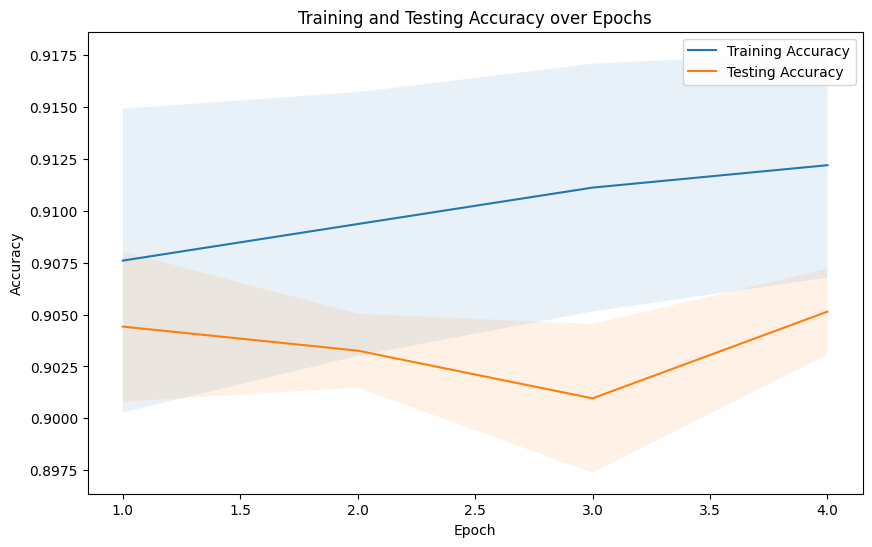

1252.0423114439982


In [60]:
import timeit

tic = timeit.default_timer()

graph_mnist(cnn_classifier, num_runs, num_epoch, model_org, x_train_org, y_train_org, x_test_org, y_test_org)

toc = timeit.default_timer()

print(toc - tic)

[0.94470999 0.94577668 0.94656333 0.94756001] [0.00501948 0.00484583 0.0044002  0.00361468] [0.94319999 0.9444     0.94342    0.94162   ] [0.00314642 0.00396788 0.00204685 0.00487418]


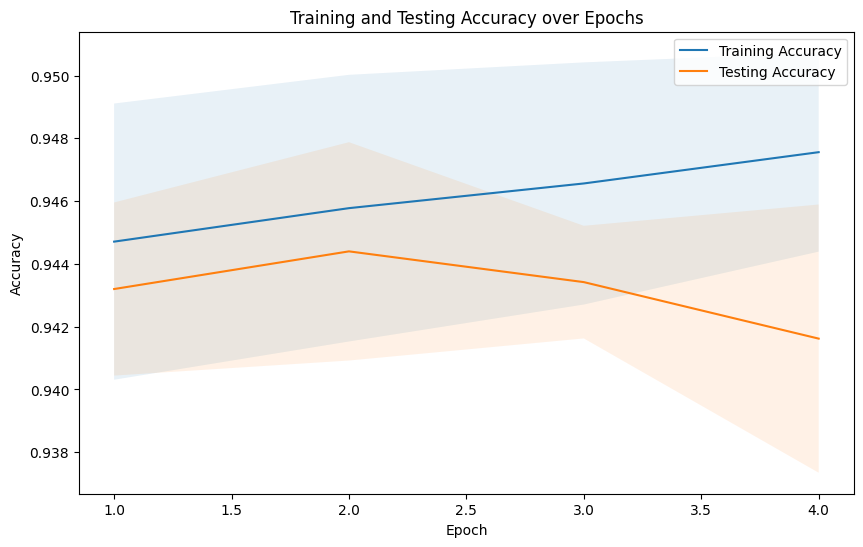

98.22146820499984


In [61]:
import timeit

tic = timeit.default_timer()

graph_mnist(cnn_classifier, num_runs, num_epoch, model_low, x_train_low, y_train_low, x_test_low, y_test_low)

toc = timeit.default_timer()

print(toc - tic)

In [62]:
import timeit

tic = timeit.default_timer()

model_org, x_train_org, y_train_org, x_test_org, y_test_org = svm_mnist("original")

toc = timeit.default_timer()

print(toc - tic)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.9752
253.14064581700222


In [63]:
import timeit

tic = timeit.default_timer()

model_low, x_train_low, y_train_low, x_test_low, y_test_low = svm_mnist("low")

toc = timeit.default_timer()

print(toc - tic)

313/313 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.927
41.42284697899959


In [64]:
import timeit

num_runs_svm = 3
num_epoch_svm = 2
svm_classifier = "SVM"

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-

[0.98694321 0.9888    ] [0.00046994 0.00041269] [0.96936667 0.97366667] [0.00018856 0.00103387]


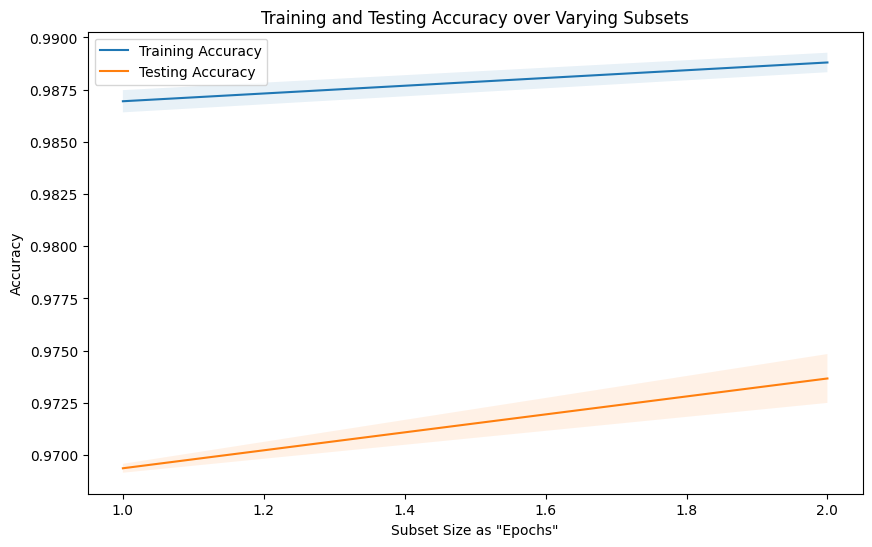

1640.778800332002


In [67]:
tic = timeit.default_timer()

graph_mnist(svm_classifier, num_runs_svm, num_epoch_svm, model_org, x_train_org, y_train_org, x_test_org, y_test_org)

toc = timeit.default_timer()

print(toc - tic)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-

[0.95543704 0.93590123] [0.00160402 0.00540118] [0.95006667 0.9342    ] [0.00103387 0.00481318]


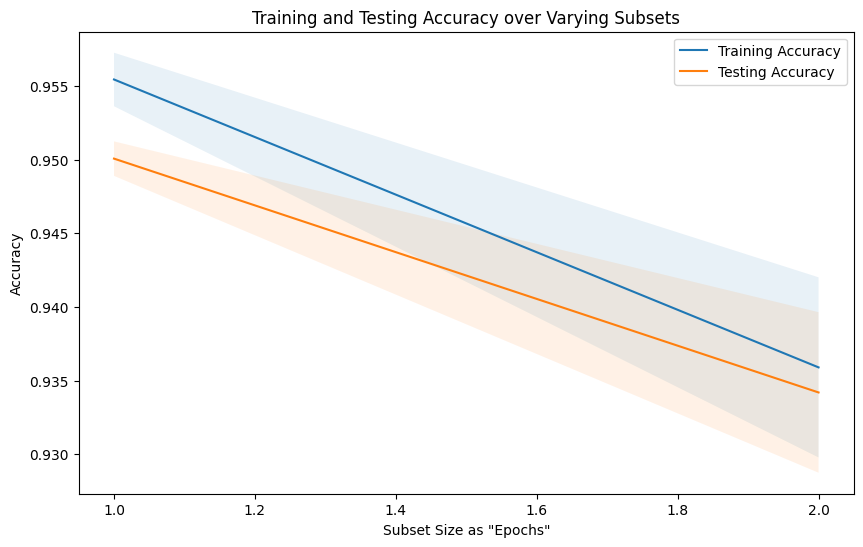

166.83672428900172


In [68]:
tic = timeit.default_timer()

graph_mnist(svm_classifier, num_runs_svm, num_epoch_svm, model_low, x_train_low, y_train_low, x_test_low, y_test_low )

toc = timeit.default_timer()

print(toc - tic)